### 1. Загрузка данных 

In [2]:
import pandas as pd
from datetime import date, timedelta 
import urllib.request
from io import open
from io import StringIO
from geopy.distance import distance
import numpy as np

Чтобы не было путаницы в источниках магнитуд возьмем данные NIED (Япония все-таки)

In [3]:
yst = "27.5"
yen = "42.5"
xst = "130"
xen = "144"
author = "NIED"
type_ = "Any"
start_time = date(1995, 1, 1)
end_time = date(2005, 1, 1)

In [4]:
url = "http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?request=COMPREHENSIVE&out_format=CATCSV&searchshape=RECT&bot_lat=" + yst + "&top_lat=" + yen + "&left_lon=" + xst + "&right_lon=" + xen + "&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&srn=&grn=&start_year=" + str(start_time.year) + "&start_month=" + str(start_time.month) + "&start_day=" + str(start_time.day) + "&start_time=00%3A00%3A00&end_year=" + str(end_time.year) + "&end_month=" + str(end_time.month) + "&end_day=" + str(end_time.day) + "&end_time=00%3A00%3A00&min_dep=&max_dep=&null_dep=on&min_mag=" + "&max_mag=&req_mag_type=" + type_ + "&req_mag_agcy=" + author

In [14]:
csv = urllib.request.urlopen(url).read().decode("utf-8") 

In [15]:
start = csv.find('...')
end = csv.find('STOP', start)
csv = csv[start + 5:end]

In [16]:
df = pd.read_csv(StringIO(csv), sep=",", on_bad_lines='skip')

In [8]:
df = df.rename(columns = {' EVENTID': 'EVENTID', 'AUTHOR   ': 'AUTHOR', 'DATE      ': 'DATE','TIME       ': 'TIME', 'LAT     ':'LAT', 'LON      ': 'LON', 'AUTHOR   .1': 'AUTHOR MAG', 'TYPE  ': 'TYPE MAG', 'MAG ': 'MAG'})

In [9]:
df.to_csv('raw_data.csv', index=False)

### 2. Обработка данных

In [93]:
import math
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('raw_data.csv')

In [7]:
df.tail()

,EVENTID,TYPE,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR MAG,TYPE MAG,MAG
6179,7457443,fe,ISC,2004-12-30,15:15:48.62,33.0934,140.7714,47.3,,NIED,Mw,3.8
6180,7457475,ke,ISC,2004-12-30,17:28:16.61,28.9417,130.5682,40.0,TRUE,NIED,Mw,4.3
6181,7457810,fe,ISC,2004-12-31,08:30:22.60,39.8090,142.4733,56.2,,NIED,Mw,4.3
6182,7457844,ke,ISC,2004-12-31,09:58:50.39,39.8976,143.5029,6.0,TRUE,NIED,Mw,4.2
6183,7458037,fe,ISC,2004-12-31,20:13:48.62,36.8474,140.9306,88.2,,NIED,Mw,5.0


In [8]:
df['COORDINATE'] = df.apply(lambda x: (x['LAT'], x['LON']), axis = 1)

In [9]:
df['DATE'] = df.apply(lambda x: date(int(x['DATE'][:4]), int(x['DATE'][5:7]), int(x['DATE'][8:10])), axis=1)

Возьмем только события, магнитуда которых, превышает магнитуду полноты $M = 3$ (хотя это вроде вся таблица и есть)

In [98]:
df = df[df['MAG'] >= 3]

Выведем средние, максимальные и минимальные значения даты/долготы/широты/магнитуды


In [99]:
statistics = df[['DATE', 'LAT', 'LON', 'MAG']].min().to_frame(name='min')
statistics['max'] = df[['DATE', 'LAT', 'LON', 'MAG']].max()

In [100]:
a = df[['LAT', 'LON', 'MAG']].mean()

Для подсчета средней даты переведем в юлианскую дату (эти функции я не от нечего делать писала - это я честно скопировала с чужого github'а)

In [101]:
def date_to_jd(year,month,day):
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month
    if ((year < 1582) or
        (year == 1582 and month < 10) or
        (year == 1582 and month == 10 and day < 15)):
        B = 0
    else:
        A = math.trunc(yearp / 100.)
        B = 2 - A + math.trunc(A / 4.)
    if yearp < 0:
        C = math.trunc((365.25 * yearp) - 0.75)
    else:
        C = math.trunc(365.25 * yearp)
    D = math.trunc(30.6001 * (monthp + 1))
    jd = B + C + D + day + 1720994.5
    return jd

In [102]:
def jd_to_date(jd):
    jd = jd + 0.5
    F, I = math.modf(jd)
    I = int(I)
    A = math.trunc((I - 1867216.25)/36524.25)
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I   
    C = B + 1524
    D = math.trunc((C - 122.1) / 365.25)
    E = math.trunc(365.25 * D)
    G = math.trunc((C - E) / 30.6001)
    day = C - E + F - math.trunc(30.6001 * G)
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
        
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return date(int(year), int(month), int(day))

In [103]:
df['JD'] = df.apply(lambda x: date_to_jd(x['DATE'].year, x['DATE'].month, x['DATE'].day), axis=1)

In [104]:
mean_JD = df['JD'].mean()

In [105]:
a['DATE'] = jd_to_date(mean_JD)

In [106]:
statistics['mean'] = a

In [107]:
statistics

,min,max,mean
DATE,1997-01-04,2004-12-31,2001-05-31
LAT,27.5117,42.5,35.387144
LON,130.0,144.0,138.937805
MAG,3.1,7.9,4.087435


Выведем также гистограммы магнитуды с точностью до целой части (для этого в частности округлим магнитуды, а не просто возьмем целую часть)

In [108]:
mx = math.ceil(df['MAG'].max())

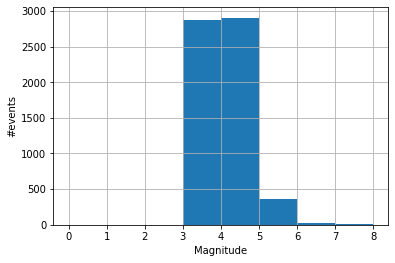

In [109]:
plt.hist(df['MAG'], np.arange(0, mx + 1, 1))
plt.grid(True)
plt.xlabel('Magnitude')
plt.ylabel('#events')
plt.show()

Выведем точное количество:

In [110]:
for i in range(0, mx + 1):
    m = df[df['MAG'].astype('int') == i].count()[0]
    print(str(i) + '-' + str(i + 1) + ': ' + str(m))
    


0-1: 0
1-2: 0
2-3: 0
3-4: 2878
4-5: 2904
5-6: 368
6-7: 29
7-8: 5
8-9: 0


### 3 Подсчет средней магнитуды и плотности землетрясений 

Посчитаем расстояние $dx$ и $dy$ - расстояния по долготе и по широте соответсвующие $R$

In [22]:
yen = float(yen)
yst = float(yst)
xen = float(xen)
xst = float(xst)

In [112]:
R_earth = 6371
y_mean = (yst + yen) / 2

Плотность будет иметь размерность $\frac{1}{\text{км}^2 \cdot \text{дни}}$

In [113]:
def density(x, df, R = 100, T = 365):
    dy = (R * 360) / (2 * np.pi * R_earth)
    dx = (R * 360) / (2 * np.pi * R_earth * np.cos(np.deg2rad(y_mean)))
    suit = [False] * df.shape[0]
    for i in range(0, df.shape[0]):
        if abs(df.iloc[i]['LON'] - x['LON']) <= dx and abs(df.iloc[i]['LAT'] - x['LAT'] <= dy):
            if distance(x['COORDINATE'], df.iloc[i]['COORDINATE']).km < R and (x['DATE'] - df.iloc[i]['DATE']) < timedelta(days = T):
                suit[i] = True
    n = suit.count(True)
    density = n / (np.pi * R ** 2 * T)
    return density


In [114]:
def mean_mag(x, df, R = 200, T = 700):
    dy = (R * 360) / (2 * np.pi * R_earth)
    dx = (R * 360) / (2 * np.pi * R_earth * np.cos(np.deg2rad(y_mean)))
    suit = [False] * df.shape[0]
    for i in range(0, df.shape[0]):
        if abs(df.iloc[i]['LON'] - x['LON']) <= dx and abs(df.iloc[i]['LAT'] - x['LAT'] <= dy):
            if distance(x['COORDINATE'], df.iloc[i]['COORDINATE']).km < R and (x['DATE'] - df.iloc[i]['DATE']) < timedelta(days = T):
                suit[i] = True
    res = suit * df['MAG']
    a = res.to_list()
    m = res.sum() / (len(a) - a.count(0))
    return m

In [117]:
%%time
df['DENSITY'] = df.apply(lambda x: density(x, df), axis = 1)

CPU times: user 1h 51min 59s, sys: 28.5 s, total: 1h 52min 28s
Wall time: 1h 52min 28s


In [118]:
%%time
df['MEAN MAG'] = df.apply(lambda x: mean_mag(x, df), axis = 1)

CPU times: user 2h 37min 39s, sys: 911 ms, total: 2h 37min 40s
Wall time: 2h 37min 41s


Считалось долго, поэтому сохраним эту таблицу на всякий пожарный

In [119]:
df.to_csv('data_edit_1.csv', index=False)

### 4. Конвертер

Будем записывать в первой строке границы прямоугольника: $x_{st}$, $x_{en}$, $y_{st}$, $y_{en}$.

Также начало временного промежутка $T_{st}$

In [14]:
import os

In [10]:
df = pd.read_csv('data_edit_1.csv')

In [11]:
df['DATE'] = df.apply(lambda x: date(int(x['DATE'][:4]), int(x['DATE'][5:7]), int(x['DATE'][8:10])), axis=1) 

In [33]:
if os.path.exists("density") == False:
    os.mkdir("density")

In [34]:
initial_path = os.getcwd()
density_path = initial_path + '/density'

In [35]:
os.chdir("density")

In [36]:
f = open('density.txt', 'w')

In [37]:
if os.path.exists("data") == False:
    os.mkdir("data")

In [38]:
os.getcwd()

'/home/alina/Рабочий стол/iitp intern/density'

In [39]:
%%time

t = start_time
i = 1
T = 365
first_line = str(xst) + ' ' + str(xen) + ' ' + str(yst) + ' ' + str(yen)

while t < end_time:
    file_name = 'density' + str(i) + '.txt'
    f.write(file_name + '\n')
    
    os.chdir("data")
    f_t = open(file_name, 'w')
    f_t.write(first_line + ' ' + str(t) + '\n')
    
    t = t + timedelta(days = T)
    df_t = df[(df['DATE'] < t) & (df['DATE'] >= (t - timedelta(days = T)))]
    x = xst
    while x < xen:
        f_t.write(str(x) + ' ')
        df_t_x = df_t[(df_t['LON'] < (x + 1)) & (df_t['LON'] >= x)].sort_values(by='LAT')
        if df_t_x.empty:
            a = ' '
        else:
            a = df_t_x['DENSITY'].to_string(index=False).replace('\n', ' ')
        f_t.write(a + '\n')
        x += 1
    f_t.close()
    os.chdir(density_path)
    i += 1

CPU times: user 236 ms, sys: 7.92 ms, total: 244 ms
Wall time: 244 ms


In [40]:
os.chdir(initial_path)
f.close()